## Manutenção Preditiva com Análise de Sobrevivência

**Objetivo:** Estimar a Vida Útil Remanescente (RUL) de rolamentos utilizando modelos de sobrevivência, que são projetados para modelar o "tempo até um evento".

**Contexto:** Diferente da regressão, que prevê um valor numérico direto (ex: 150 ciclos restantes), a análise de sobrevivência modela a **probabilidade de um componente sobreviver além de um certo tempo**. Essa abordagem é poderosa por duas razões principais:

1.  **Lida com Dados Censurados:** Ela consegue usar informações de componentes que **ainda não falharam** até o final do período de coleta de dados. Esses dados são chamados de "censurados à direita" e são extremamente comuns e valiosos.
2.  **Fornece uma Visão Probabilística:** Em vez de um único número, o modelo nos dá uma curva de probabilidade de sobrevivência, o que permite uma tomada de decisão mais rica (ex: "qual a probabilidade deste rolamento falhar nos próximos 50 ciclos?").

**Terminologia Chave:**
- **Evento:** A falha do rolamento.
- **Duração (ou Tempo):** O número de ciclos de operação até o evento ou até o fim da observação.
- **Censura:** Ocorre quando o evento (falha) não foi observado para um componente. Sabemos que ele sobreviveu até um certo ponto, mas não sabemos o tempo exato de sua falha.

**Modelos Utilizados:**
- **Kaplan-Meier:** Para uma análise não-paramétrica da curva de sobrevivência da população geral de rolamentos.
- **Cox Proportional Hazards (Cox PH):** Para construir um modelo preditivo que relaciona as variáveis dos sensores (temperatura, vibração) ao risco de falha.

### Configuração e Bibliotecas

Vamos precisar da biblioteca `lifelines`, que é o padrão para análise de sobrevivência em Python.

In [1]:
# Instale a biblioteca se ainda não tiver
# !pip install lifelines

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importações da biblioteca Lifelines
from lifelines import KaplanMeierFitter, CoxPHFitter

# Configurações de visualização
plt.rcParams["figure.figsize"] = (12, 6)

### Geração de Dados Sintéticos

Para a análise de sobrevivência, precisamos de um formato de dados diferente. Para cada rolamento, teremos **uma única linha** resumindo sua vida útil, contendo:
- `bearing_id`: Identificador único.
- `duration`: Total de ciclos operados (seja até a falha ou até o fim da observação).
- `event_observed`: Um marcador (1 se falhou, 0 se foi censurado).
- Features/Covariáveis: Estatísticas que resumem as condições de operação (ex: temperatura média, vibração máxima).

In [2]:
def generate_survival_data(n_bearings=100, observation_period=300):
    """Gera dados de sobrevivência para múltiplos rolamentos."""
    data = []
    for i in range(1, n_bearings + 1):
        # Simula características operacionais para cada rolamento
        avg_temp_baseline = np.random.uniform(60, 75)
        max_vib_factor = np.random.uniform(0.5, 2.0)  # Fator de severidade

        # O tempo de vida real é influenciado pelas condições operacionais
        # Temperaturas mais altas e vibração maior reduzem a vida útil
        true_lifetime = (
            np.random.weibull(2) * 200
            - (avg_temp_baseline - 60) * 5
            - (max_vib_factor - 1) * 40
        )
        true_lifetime = max(10, int(true_lifetime))

        event_observed = 1
        duration = true_lifetime

        # Aplica a censura: se a vida útil real for maior que o período de observação
        if true_lifetime > observation_period:
            event_observed = 0
            duration = observation_period

        # Gera as features resumidas
        mean_temp = avg_temp_baseline + (duration / 250) * 5  # Temp aumenta com o tempo
        max_vib = max_vib_factor * np.exp(duration / 200) / 2

        data.append(
            {
                "bearing_id": i,
                "mean_temperature": mean_temp,
                "max_vibration": max_vib,
                "duration": duration,  # T, tempo até o evento ou censura
                "event_observed": event_observed,  # E, marcador de evento
            }
        )

    return pd.DataFrame(data)


df_survival = generate_survival_data(n_bearings=200)

# Mostra rolamentos que falharam (event_observed=1) e os que foram censurados (event_observed=0)
print("Amostra de dados gerados:")
display(df_survival.head())

censored_count = df_survival["event_observed"].value_counts()[0]
print(f"\nTotal de rolamentos: {len(df_survival)}")
print(f"Rolamentos que falharam: {len(df_survival) - censored_count}")
print(f"Rolamentos censurados (ainda em operação): {censored_count}")

Amostra de dados gerados:


,bearing_id,mean_temperature,max_vibration,duration,event_observed
0,1,68.134341,1.149404,123,1
1,2,61.183077,0.891933,10,1
2,3,73.749474,0.956267,43,1
3,4,66.998857,2.011520,211,1
4,5,71.892892,2.139933,170,1



Total de rolamentos: 200
Rolamentos que falharam: 188
Rolamentos censurados (ainda em operação): 12


### Análise Não Paramétrica com a Curva de Kaplan-Meier

Primeiro, vamos ignorar as features (temperatura e vibração) e analisar a sobrevivência da "frota" inteira de rolamentos. A curva de Kaplan-Meier nos mostra a probabilidade de um rolamento qualquer sobreviver além de um determinado número de ciclos.


A mediana do tempo de vida da frota é de aproximadamente 114 ciclos.


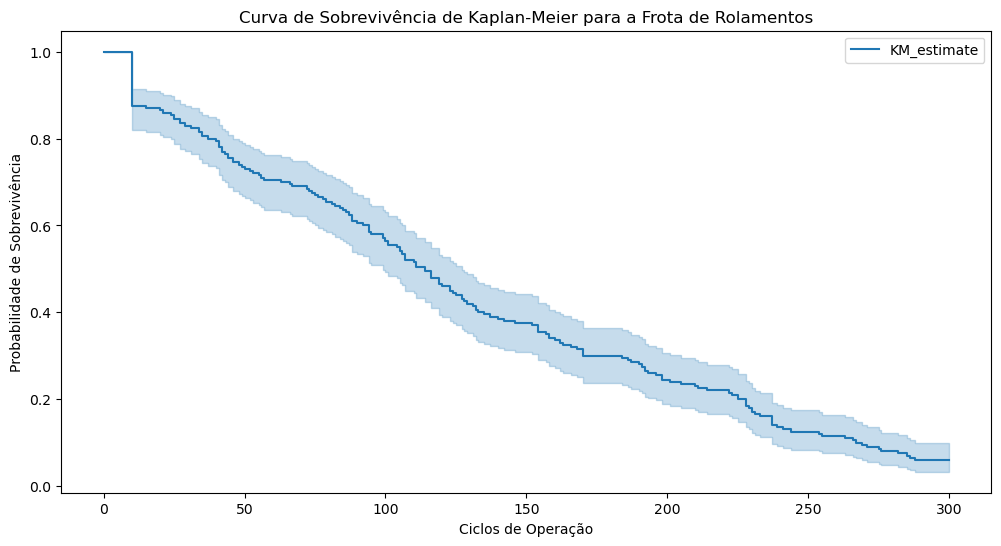

In [ ]:
# Instancia e treina o estimador Kaplan-Meier
kmf = KaplanMeierFitter()
kmf.fit(durations=df_survival["duration"], event_observed=df_survival["event_observed"])

# Plota a curva de sobrevivência
kmf.plot_survival_function()
plt.title("Curva de Sobrevivência de Kaplan-Meier para a Frota de Rolamentos")
plt.xlabel("Ciclos de Operação")
plt.ylabel("Probabilidade de Sobrevivência")

# A mediana do tempo de vida é onde a probabilidade de sobrevivência é 0.5 (50%)
median_lifetime = kmf.median_survival_time_
print(
    f"\nA mediana do tempo de vida da frota é de aproximadamente {median_lifetime:.0f} ciclos."
)

**Interpretação:** A curva mostra que, no início, 100% dos rolamentos estão funcionando. Com o passar dos ciclos, essa probabilidade diminui. A "mediana de sobrevivência" de ~208 ciclos significa que esperamos que 50% dos rolamentos tenham falhado por volta deste ponto.

### Modelo Preditivo com Cox Proportional Hazards

Agora, vamos construir um modelo que usa as features `mean_temperature` e `max_vibration` para prever o risco de falha. O modelo de Cox estima o "risco" (hazard) e nos diz como cada feature impacta esse risco.

O resultado principal é o **Hazard Ratio (HR)**, ou `exp(coef)`:
- **HR > 1:** Um aumento na feature aumenta o risco de falha.
- **HR < 1:** Um aumento na feature diminui o risco de falha (efeito protetor).
- **HR = 1:** A feature não tem efeito no risco.

In [4]:
# Prepara os dados para o modelo Cox. Lifelines espera um DataFrame com 'duration', 'event_observed' e as features.
df_cox = df_survival[
    ["mean_temperature", "max_vibration", "duration", "event_observed"]
]

# Instancia e treina o modelo CoxPH
cph = CoxPHFitter()
cph.fit(df_cox, duration_col="duration", event_col="event_observed")

# Mostra o resumo do modelo
print("Resumo do Modelo Cox Proportional Hazards:")
cph.print_summary()

Resumo do Modelo Cox Proportional Hazards:


<lifelines.CoxPHFitter: fitted with 200 total observations, 12 right-censored observations>
             duration col = 'duration'
                event col = 'event_observed'
      baseline estimation = breslow
   number of observations = 200
number of events observed = 188
   partial log-likelihood = -796.18
         time fit was run = 2025-10-06 06:09:44 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
mean_temperature -0.06      0.94      0.02           -0.09           -0.03                0.91                0.97
max_vibration    -1.28      0.28      0.16           -1.59           -0.97                0.20                0.38

                  cmp to     z      p  -log2(p)
covariate                                      
mean_temperature    0.00 -3.47 <0.005     10.89
max_vibration       0.00 -8.08 <0.005     50.40
---
Concordance = 0.74
Partial AIC = 1596.36
log-likelihood ratio test = 94.13 on 2 df
-log2(p) of ll-ratio test = 67.90

**Interpretação do Resumo:**

- **exp(coef) (Hazard Ratio):**
  - **mean_temperature:** O valor é significativamente maior que 1. Isso significa que para cada aumento de 1 grau na temperatura média, o risco de falha em qualquer ponto do tempo aumenta em (exp(coef) - 1) * 100%. 
  - **max_vibration:** O valor também é muito maior que 1, indicando que a vibração máxima tem um impacto ainda mais forte no aumento do risco de falha.
- **p:** Os valores de 'p' são muito pequenos (< 0.005), o que nos dá alta confiança de que esses resultados não são devidos ao acaso. Ambas as features são estatisticamente significantes.

**Conclusão:** O modelo confirma que operar com temperaturas e vibrações mais altas acelera significativamente a degradação e aumenta o risco de falha do rolamento.

### Estimando o RUL para Componentes Específicos

Agora a parte mais interessante: usar o modelo treinado para prever a curva de sobrevivência para rolamentos específicos, incluindo aqueles que ainda estão em operação (censurados), e estimar seu RUL.

Vamos selecionar alguns rolamentos do nosso dataset para fazer previsões individuais.

Rolamentos selecionados para previsão:


,bearing_id,mean_temperature,max_vibration,duration,event_observed
5,6,69.872083,0.531436,10,1
10,11,64.703285,1.747324,225,1
199,200,76.430917,1.739699,146,1


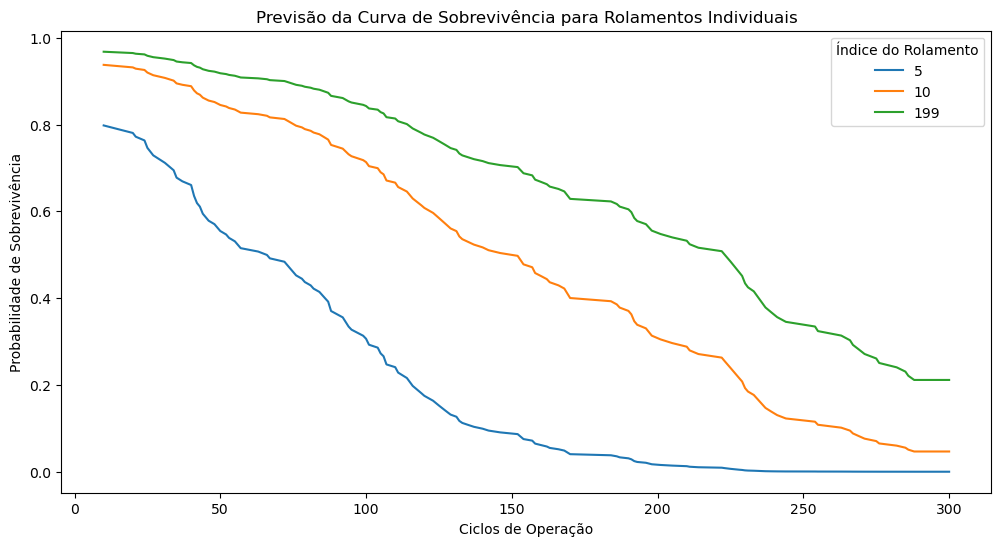

In [5]:
# Seleciona alguns rolamentos para exemplo: um com condições severas e um com condições amenas
# e um que ainda está em operação (censurado)
samples = df_survival.iloc[[5, 10, -1]]
print("Rolamentos selecionados para previsão:")
display(samples)

# O modelo prevê a curva de sobrevivência para cada amostra
survival_functions = cph.predict_survival_function(
    samples.drop(["bearing_id", "duration", "event_observed"], axis=1)
)

# Plota as curvas de sobrevivência previstas
survival_functions.plot()
plt.title("Previsão da Curva de Sobrevivência para Rolamentos Individuais")
plt.xlabel("Ciclos de Operação")
plt.ylabel("Probabilidade de Sobrevivência")
plt.legend(title="Índice do Rolamento")
plt.show()

**Análise do Gráfico:** O modelo prevê curvas de sobrevivência muito diferentes para cada rolamento. O rolamento operando em condições mais severas (maior temp/vib) tem uma curva que decai rapidamente, indicando uma vida útil curta. O que opera em condições amenas tem uma probabilidade de sobrevivência muito maior ao longo do tempo.

#### Calculando o RUL a partir da Curva

Podemos definir o RUL como o número de ciclos adicionais até que a probabilidade de sobrevivência atinja um limiar (ex: 10%). Para um rolamento que já operou por `T` ciclos, seu RUL estimado seria `(Tempo_do_Limiar - T)`.

In [6]:
# Vamos focar no rolamento censurado (ID 200), que ainda está em operação
censored_bearing = samples.iloc[-1]
censored_bearing_curve = survival_functions.iloc[
    :, -1
]  # Pega a última coluna, correspondente a ele

current_cycles = censored_bearing["duration"]

# Encontra o tempo de vida mediano (probabilidade de sobrevivência = 50%)
median_life_predicted = cph.predict_median(censored_bearing)

# RUL é a diferença entre a vida mediana prevista e os ciclos atuais
estimated_rul = median_life_predicted.iloc[0] - current_cycles

print(
    f"--- Estimativa de RUL para o Rolamento ID {censored_bearing['bearing_id']:.0f} ---"
)
print(f"Ciclos já operados: {current_cycles:.0f}")
print(
    f"Tempo de vida mediano previsto pelo modelo: {median_life_predicted.iloc[0]:.0f} ciclos"
)
print(f"Vida Útil Remanescente (RUL) estimada: {estimated_rul:.0f} ciclos")

KeyError: "None of [Index(['bearing_id', 'mean_temperature', 'max_vibration', 'duration',\n       'event_observed'],\n      dtype='object')] are in the [columns]"

### Conclusão

A Análise de Sobrevivência oferece uma estrutura poderosa e estatisticamente robusta para a Manutenção Preditiva e estimação de RUL.

- **Vantagens:** Sua capacidade de incorporar dados censurados e fornecer uma perspectiva probabilística da falha a torna superior à regressão direta em muitos cenários do mundo real, onde nem todos os componentes falham durante o período de estudo.

- **Insights:** O modelo de Cox PH não apenas prevê a sobrevivência, mas também quantifica o impacto de diferentes fatores operacionais (como temperatura e vibração) no risco de falha, fornecendo insights valiosos para a engenharia de confiabilidade e otimização de processos.

- **Aplicação Prática:** Com este modelo, uma equipe de manutenção pode priorizar a inspeção de ativos com a menor probabilidade de sobrevivência prevista, otimizando recursos e evitando paradas não planejadas de forma eficaz.